In [1]:
# installation of Weights & Biases
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


In [2]:
# import of libraries
import wandb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pickle

In [3]:
# wandb login
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Getting the artifacts from wandb

In [4]:
# Initializing a W&B run.
run = wandb.init(entity="flamigos", project="cnn_animation", job_type="train model")

wandb: Currently logged in as: valmirfrancisco1 (flamigos). Use `wandb login --relogin` to force relogin


In [5]:
# getting the train artifacts
artifact = run.use_artifact('flamigos/cnn_animation/label_data_train:latest', type='split_data').file()
artifact2 = run.use_artifact('flamigos/cnn_animation/img_data_train:latest', type='split_data').file()
labels = pd.read_csv(artifact)
labels = labels["animation Type"]
data_img = np.load(artifact2)

In [6]:
# watching the label values
print(len(labels))
count_zeros = np.count_nonzero(labels == 0)
print(count_zeros)
count_zeros = np.count_nonzero(labels == 0)
print(count_zeros)

7113
3557
3557


# Split data from train and validate the train

In [7]:
# dividing training and validation values
X_train, X_test, y_train, y_test = train_test_split(data_img, labels, test_size=0.2, random_state=42, stratify=labels)

# Creating Our Model

In [8]:
# Architecture made by KANAK MITTAL

model = tf.keras.Sequential([
    # CONVOLUTIONAL PART
    # performs convolution operations with 32 filters to detect patterns in each 4 pixels (2x2)
    # input_shape indicates that it expects to use 128px by 128px images in RGBA format
    tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=(128, 128, 4)),
    # max pooling operation has the effect of reducing the spatial resolution of the input, keeping only the maximum values within the pooling window
    tf.keras.layers.MaxPooling2D((4,4)),

    # adds pixels with a value of 0 to the edge of the image, preventing underutilization of the edges
    tf.keras.layers.ZeroPadding2D(padding=(1,1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D((3,3)),
    # the idea behind dropout is to randomly deactivate a fraction of neurons during training, thus avoiding overfitting
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),

    # NEURAL NETWORK PART
    # the Flatten layer in a neural network is used to convert multidimensional input data into a single dimension
    tf.keras.layers.Flatten(),
    # internal or hidden layers of the neural network
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    # Output layer with 2 neurons (anime or cartoon) using softmax function providing probabilities of belonging to each class
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 zero_padding2d (ZeroPaddin  (None, 33, 33, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                        

In [9]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=('accuracy'))

In [10]:
# using early stopping to exit training if validation accuracy is not growing even after certain epochs (patience)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 50)

In [11]:
# save the best model with higher validation accuracy
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="animevscartoon_weights.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')

In [12]:
# train of the model and the history of results of this train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[checkpointer, earlystopping])

Epoch 1/100
89/89 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5095
Epoch 1: val_accuracy improved from -inf to 0.62122, saving model to animevscartoon_weights.hdf5
89/89 [==============================] - 14s 59ms/step - loss: 0.6926 - accuracy: 0.5095 - val_loss: 0.6669 - val_accuracy: 0.6212
Epoch 2/100
 3/89 [>.............................] - ETA: 2s - loss: 0.6727 - accuracy: 0.6458

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/89 [============================>.] - ETA: 0s - loss: 0.6119 - accuracy: 0.6870
Epoch 2: val_accuracy improved from 0.62122 to 0.70274, saving model to animevscartoon_weights.hdf5
89/89 [==============================] - 4s 41ms/step - loss: 0.6105 - accuracy: 0.6882 - val_loss: 0.5782 - val_accuracy: 0.7027
Epoch 3/100
89/89 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.7518
Epoch 3: val_accuracy improved from 0.70274 to 0.76037, saving model to animevscartoon_weights.hdf5
89/89 [==============================] - 4s 40ms/step - loss: 0.5295 - accuracy: 0.7518 - val_loss: 0.5078 - val_accuracy: 0.7604
Epoch 4/100
89/89 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.7657
Epoch 4: val_accuracy improved from 0.76037 to 0.77864, saving model to animevscartoon_weights.hdf5
89/89 [==============================] - 3s 38ms/step - loss: 0.5014 - accuracy: 0.7657 - val_loss: 0.4604 - val_accuracy: 0.7786
Epoch 5/100
89/89 [==================

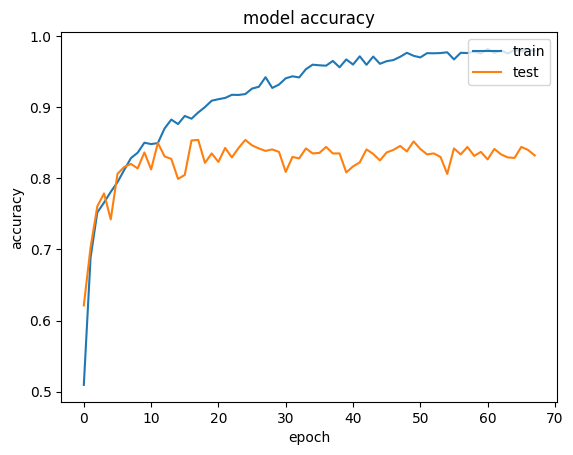

In [13]:
# graph of model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

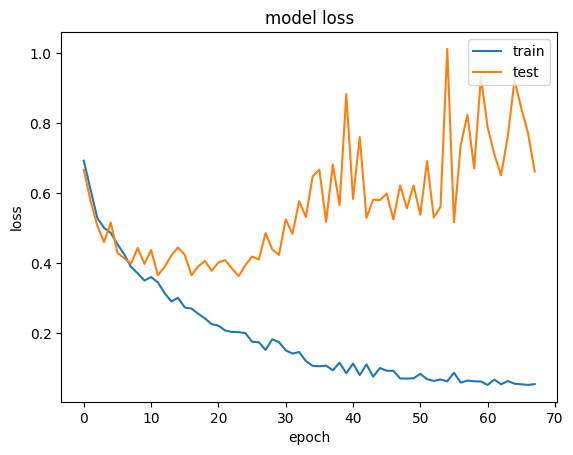

In [14]:
# graph of model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Creating our pipelineclass

In [15]:
# Custom pipeline class file
%%file imageProcessor.py

import numpy as np
from PIL import Image
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ImageProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, target_size=(128, 128)):
        self.target_size = target_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        processed_images = []

        for item in X:
            if isinstance(item, np.ndarray):
                # If it's a numpy array, we assume it's already in the correct form
                im = item.astype('float32')
                # Check if values are already divided by 255
                if im.max() > 1.0:
                    # Normalize pixel values
                    im /= 255.0
            elif isinstance(item, Image.Image):
                # If it's an instance of Image (Pillow), apply transformations
                im = item.copy()
                # Convert the image to RGBA mode if it's not in this format
                if im.mode != 'RGBA':
                    im = im.convert('RGBA')
                # Resize the image to the desired size
                im = im.resize(self.target_size)
                # Convert the image to a float32 numpy array
                im = np.array(im, dtype='float32')
                # Check if values are already divided by 255
                if im.max() > 1.0:
                    # Normalize pixel values
                    im /= 255.0
            else:
                raise ValueError("Unsupported input type.")

            # Add the processed image to the results list
            processed_images.append(im)

        return np.array(processed_images)

Writing imageProcessor.py


In [16]:
# import the class of py archive we create
from imageProcessor import ImageProcessor

In [17]:
loaded_model = tf.keras.models.load_model('animevscartoon_weights.hdf5')

In [18]:
# creating a pipeline with normalizer and the trained model
pipeline = Pipeline([
    ('normalizer', ImageProcessor(target_size=(128, 128))),
    ('model', loaded_model)
])

## Using the Pipeline

In [19]:
predictions = pipeline.predict(X_test)

45/45 [==============================] - 1s 10ms/step


In [20]:
predict = []
for i in predictions:
    predict.append(np.argmax(i))

In [21]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       712
           1       0.85      0.86      0.86       711

    accuracy                           0.85      1423
   macro avg       0.85      0.85      0.85      1423
weighted avg       0.85      0.85      0.85      1423



# Put the pipeline into wandb

In [22]:
from joblib import dump, load

In [23]:
dump(pipeline, 'pipe.joblib')

['pipe.joblib']

In [24]:
# creating a wandb artifact
artifact = wandb.Artifact(name="animation_model_pipeline",
                                type="pipeline",
                                description="pipeline of the trained animation model",
      )

# add the file to the artifact
artifact.add_file("/content/pipe.joblib")
# save the artifact in W&B
wandb.run.log_artifact(artifact)

<Artifact animation_model_pipeline>

# Put the python class into wandb

In [25]:
# creating a wandb artifact
artifact = wandb.Artifact(name="imageProcessor_class",
                                type="python",
                                description="class needed to use in transform of our pipeline",
      )

# add the file to the artifact
artifact.add_file("/content/imageProcessor.py")
# save the artifact in W&B
wandb.run.log_artifact(artifact)

<Artifact imageProcessor_class>

In [26]:
# finish the run
run.finish()